In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Swaptionvol


In [3]:
datafile = pd.read_excel('Invertir_Smile_Mercado_Swaption.xlsx')   #import data from excel file
FS = datafile.iloc[22,2]*100
Premium_put = datafile.iloc[10,4:11].values/100
Premium_call = datafile.iloc[10,11:17].values/100
K_put = datafile.iloc[11,4:11].values*100; K_call = datafile.iloc[11,11:17].values*100
K = np.concatenate((np.hstack(K_put),np.hstack(K_call)),axis=None)
Annuity = datafile.iloc[20,2]; Expiry = datafile.iloc[5,4]
ATMstrike = K[np.nonzero(K == FS)]

Volatilidades ímplicitas en los Swaption según el modelo Normal (Bachelier). Para obtenerlas he utilizado el método de Newton-Raphson.

In [4]:
sigmacall = []; sigmaput = [];
for i in range(K_call.size):
    sigmacall.append(Swaptionvol.SwaptionNormalvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],1))
for j in range(K_put.size):
    sigmaput.append(Swaptionvol.SwaptionNormalvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],-1))
sigmaMKT = np.asarray(sigmaput + sigmacall)

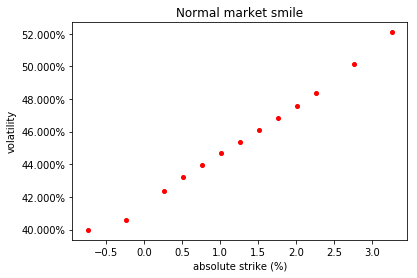

In [5]:
sigmaMKT = np.asarray(sigmaput + sigmacall)
plt.plot(K,sigmaMKT,'ro',markersize=4); plt.title('Normal market smile');
plt.ylabel("volatility"); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]);  #vol as %

# Calibración del SABR (normal)
A partir de la volatilidad de mercado implícita en un swaption 20Y_20Y obtenida a través del modelo normal (Bachelier).
Parámetros fijados: $\beta = 0.5$ y $s = 1\%$. Como minimizador de la función objetivo he utilizado el método *L-BFGS-B* y como condiciones iniciales, para $\alpha$ he utilizado el valor de la volatilidad de mercado para un swaption ATM, y para los otros dos parámetros $\rho$ y $\nu$ el valor 0.01, con las condiciones de contorno clásicas

Los parámetros estimados: [alpha, rho, nu] =  [ 0.34408899 -0.58097891  0.16243724]


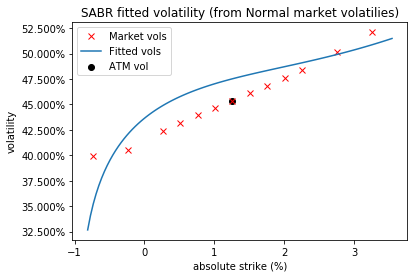

In [6]:
import SABRnormalsmile
s = 1; beta = 0.5;
SABRBlparam = SABRnormalsmile.SABRNormalcalb(FS,K,sigmaMKT,Expiry,beta,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalsmile.SABRNormalplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Normal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

Y ahora realizo la calibración añadiendo $\beta$ como un parámetro más a estimar $(s=1)$

Los parámetros estimados: [alpha, rho, nu, beta] =  [ 0.37327295 -0.61124663  0.09164037  0.37440008]


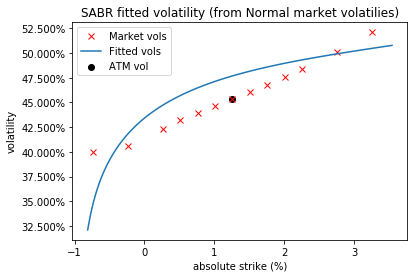

In [7]:
# Bachelier (Normal) SABR parametrization (estimating beta)
import SABRnormalsmilebeta
s =1;
SABRBlparam = SABRnormalsmilebeta.SABRNormalcalb(FS,K,sigmaMKT,Expiry,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalsmilebeta.SABRNormalplot(SABRBlparam,FS,X,Expiry,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Normal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu, beta] = ', SABRBlparam)

Por lo tanto, como la $\beta$ es similar pero si no es estima se ajusta mejor al mercado, continuo fijando la $\beta$.
Aquí es donde me entran dudas, yo creo que está bien programado pero no parece que ajuste bien el smile.

## Calibración del (shifted) SABR con $\alpha$ implícita

Los parámetros estimados: [alpha, rho, nu] =  [0.582771328337519, -0.9999, 0.20299519364265187]


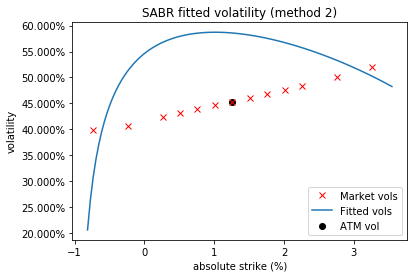

In [20]:
import SABRnormalmethod2
s = 1; beta = 0.3;
SABRBlparam = SABRnormalmethod2.SABRNormalcalb(FS,K,sigmaMKT,Expiry,beta,s)    #calibrate SABR

def alpha(rho,nu):
    raices = np.roots([(1-beta)**2*Expiry/(24*FS**(2-2*beta)),beta*rho*nu*Expiry/(4*FS**(1-beta)),
             1 + (2-3*rho**2)*nu**2*Expiry/24,-sigmaMKT[np.nonzero(K == FS)]*FS**(1-beta)])
    raices = raices[np.isreal(raices) == 1] #returns only real numbers
    raiz = np.amin(raices[raices>0])     #returns minimum positive value
    return raiz.real

SABRBlparam = [alpha(SABRBlparam[0],SABRBlparam[1]),SABRBlparam[0],SABRBlparam[1]]

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalmethod2.SABRNormalplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (method 2)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

# Volatilidades a partir del modelo lognormal (Black)

Como hay strikes negativos habrá valores para los que el logaritmo no esté definido, por lo tanto aplico un shift al Forward Swap Rate y a los Strikes de $s=1\%$

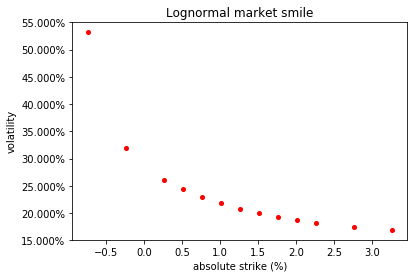

In [8]:
sigmacall2 = []; sigmaput2 = []; s = 1
for i in range(K_call.size):
    sigmacall2.append(Swaptionvol.SwaptionLognvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],s,1));
for j in range(K_put.size):#range(K_put.size):
    sigmaput2.append(Swaptionvol.SwaptionLognvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],s,-1));
sigmaMKT2 = np.asarray(sigmaput2 + sigmacall2);
plt.plot(K,sigmaMKT2,'ro',markersize=4); plt.title('Lognormal market smile');
plt.ylabel("volatility"); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]); #vol as %

# Calibración del SABR (modelo Black)
Fijo los parámetros en los valores anteriores, $\beta=0.5$ y $s=1\%$, y realizo los mismos pasos que en el caso anterior pero con la volatilidad implícita correspondiente a este modelo

Los parámetros estimados: [alpha, rho, nu] =  [ 0.27041032 -0.26424126  0.31055927]


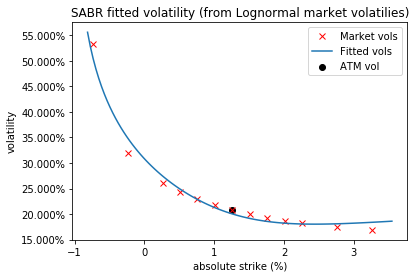

In [9]:
import SABRlognsmile
s = 1 ; beta = 0.5;
SABRBlparam = SABRlognsmile.SABRBlcalb(FS,K,sigmaMKT2,Expiry,beta,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRlognsmile.SABRBlplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Lognormal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

Los parámetros estimados: [alpha, rho, nu, beta] =  [0.41066624 0.01344246 0.01746398 0.14031986]


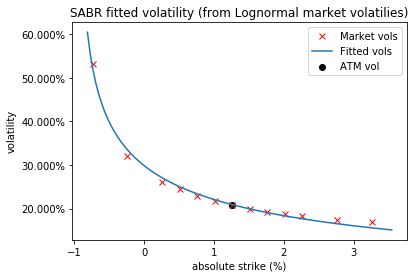

In [10]:
import SABRlognsmilebeta
s = 1;
SABRBlparam = SABRlognsmilebeta.SABRBlcalb(FS,K,sigmaMKT2,Expiry,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRlognsmilebeta.SABRBlplot(SABRBlparam,FS,X,Expiry,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Lognormal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu, beta] = ', SABRBlparam)

## Calibración del (shifted) SABR lognormal con $\alpha$ implícita

Ahora implemento el segundo método, donde el valor de $\alpha$ se obtiene a partir de la volatilidad ATM como función de $\rho$ y $\nu$, resolviendo en cada iteración del metodo de convergencia una ecuación de grado 3. De este polinomio cúbico se selecciona la raíz real positiva más pequeña. Los valores iniciales utilizados en el algoritmo de minimización (*L-BFGS-B*) son los utilizados anteriormente $(\rho,\nu) = (0.01,0.01)$, al igual que las restricciones

Los parámetros estimados: [alpha, rho, nu] =  [0.4960395646158718, -0.02237578225810146, 0.042458378230028834]


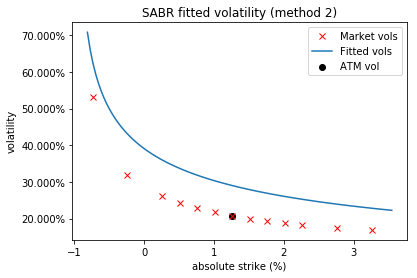

In [19]:
import SABRlognmethod2
s = 1; beta = 0.3;
SABRBlparam = SABRlognmethod2.SABRBlcalb(FS,K,sigmaMKT2,Expiry,beta,s)    #calibrate SABR

def alpha(rho,nu):
    raices = np.roots([(1-beta)**2*Expiry/(24*FS**(2-2*beta)),beta*rho*nu*Expiry/(4*FS**(1-beta)),
             1 + (2-3*rho**2)*nu**2*Expiry/24,-sigmaMKT[np.nonzero(K == FS)]*FS**(1-beta)])
    raices = raices[np.isreal(raices) == 1] #returns only real numbers
    raiz = np.amin(raices[raices>0])     #returns minimum positive value
    return raiz.real

SABRBlparam = [alpha(SABRBlparam[0],SABRBlparam[1]),SABRBlparam[0],SABRBlparam[1]]

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRlognmethod2.SABRBlplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (method 2)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

Parece que con este segundo método se obtienen peores resultados, y parece que está únicamente relacionado con el nivel de $\alpha$ (pues la curva está desplazada hacia arriba), por lo tanto a primera vista parece que este segundo método es peor que el primero